# Use CMIP6 models together with observational data
This example demonstrates how to combine CMIP6 models with observational data from the Copernicus Climate Data Store (CDS). We have chosen Surface Downwelling Longwave Radiation (rlds variable) here. We will load the data, regrid the observational dataset and use it to validate the model. First, load all nesessary libraries.

In [3]:
import intake
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xesmf as xe
import cf_xarray as cfxr
import ESMF

%matplotlib inline
print("Using xESMF in version %s" % xe.__version__)

Using xESMF in version 0.6.3


# 1. Load the model
We then load one of the historical monthly CMIP6 models for December 2014 from Mistral, look at its metadata, and plot it.

In [3]:
col = intake.open_esm_datastore("/pool/data/Catalogs/dkrz_cmip6_disk.json")
cat = col.search(variable_id = "rlds",
                 table_id = "Amon",
                 activity_id = "CMIP",
                 experiment_id = "historical",
                source_id = "MPI-ESM1-2-HR",
                member_id = "r1i1p1f1")
xr_dict = cat.to_dataset_dict()
dset = xr_dict[list(xr_dict.keys())[0]]
dset['rlds']


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.source_id.experiment_id.table_id.grid_label'


,Array,Chunk
Bytes,556.88 MiB,16.88 MiB
Shape,"(1, 1980, 192, 384)","(1, 60, 192, 384)"
Count,68 Graph Layers,33 Chunks
Type,float32,numpy.ndarray


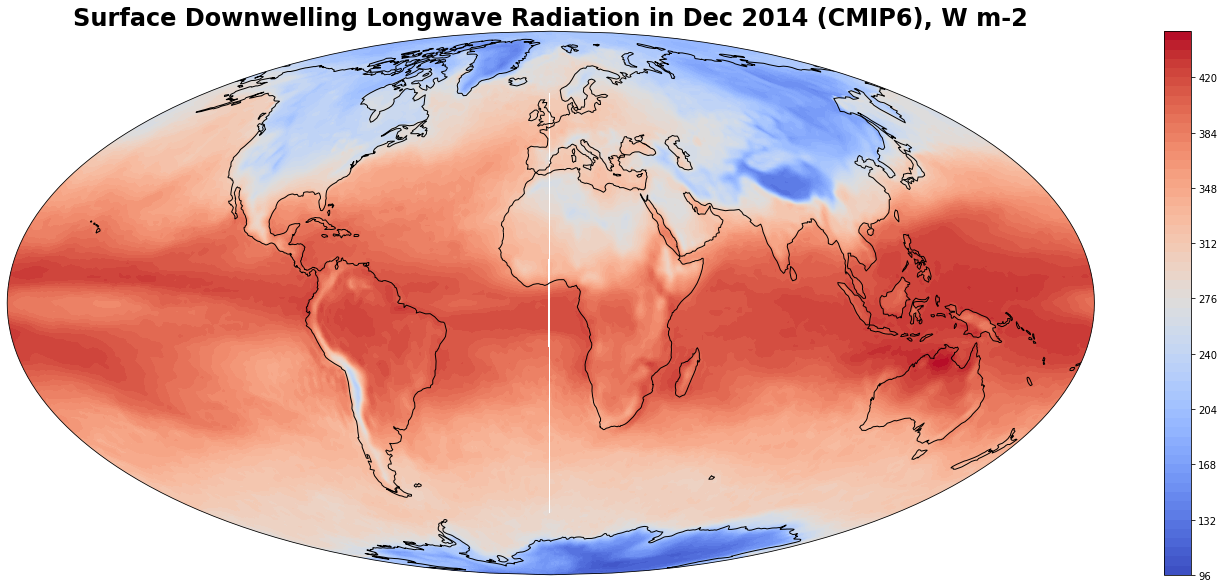

In [4]:
fig = plt.figure(figsize = (25, 10))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.Mollweide())

plt.contourf(dset['rlds'].sel(time = '2014-12-16T12:00:00')[0].lon,
            dset['rlds'].sel(time = '2014-12-16T12:00:00')[0].lat,
            dset['rlds'].sel(time = '2014-12-16T12:00:00')[0], 60,
            transform = ccrs.PlateCarree(0),
            cmap = 'coolwarm')
ax.coastlines()
ax.set_global()

# Add a color bar
plt.colorbar(ax = ax)
plt.title('Surface Downwelling Longwave Radiation in Dec 2014 (CMIP6), W m-2', 
          fontdict = {'fontsize' : '24', 'fontweight' : 'bold'} )
plt.show()

## 2. Load the observational data
As an observational dataset we chose the Surface Downwelling Longwave Radiation derived from AHVRR satellite. We download it from the Climate Data Store.
https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-surface-radiation-budget?tab=form

### In sections 2.0 - 2.1 we describe how to retrive the observational dataset from CDS. For the purpose of this workshop, however, we have already prepared this dataset, so you can directly load it in section 2.2.

### 2.0 CDS API
In order to do so we used CDS API which we need to set up first. Please refer to the source git repository for the details on the installation and use of this package.
https://github.com/ecmwf/cdsapi

You would need to enter your UID and your API Key to use CDS.

In [1]:
#!pip install cdsapi
# cat > ~/.cdsapirc
# url: https://cds.climate.copernicus.eu/api/v2
# key: <your UID>:<your API Key>
# verify: 0
#pip install cfgrib

In [4]:
# import cdsapi
# import cfgrib
# cds = cdsapi.Client()

### 2.1 Downlod the data from the CDS
We download the dataset for the same month as our modeling daset, unzip it, load it to the notebook, check its metadata, and finally plot it.

In [5]:
# cds.retrieve(
#     'satellite-surface-radiation-budget',
#     {
#         'format': 'tgz',
#         'product_family': 'clara',
#         'origin': 'eumetsat',
#         'variable': 'surface_downwelling_longwave_flux',
#         'time_aggregation': 'monthly_mean',
#         'climate_data_record_type': 'thematic_climate_data_record',
#         'year': '2014',
#         'month': '12',
#         'version': 'v2_0',
#         'sensor_on_satellite': 'avhrr_on_multiple_satellites',
#     },
#     'download.tar.gz')

/work/bm0021/conda-envs-public/summerschool_2022/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cds.climate.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
2022-08-29 19:08:37,574 INFO Welcome to the CDS
2022-08-29 19:08:37,575 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-surface-radiation-budget
/work/bm0021/conda-envs-public/summerschool_2022/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cds.climate.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
2022-08-29 19:08:37,875 INFO Request is completed
2022-08-29 19:08:37,878 INFO Downloading https://d

Result(content_length=6580570,content_type=application/gzip,location=https://download-0011-clone.copernicus-climate.eu/cache-compute-0011/cache/data7/dataset-satellite-surface-radiation-budget-9bdf94eb-2630-4580-9f84-602298b92329.tar.gz)

In [2]:
#!tar -xvf download.tar.gz SDLmm20141201000000219AVPOS01GL.nc -C /obs/

In [6]:
obs = xr.open_dataset("../../data/SDLmm20141201000000219AVPOS01GL.nc").isel(time = 0)
obs

<xarray.Dataset>
Dimensions:    (lon: 1440, lat: 720, nv: 2)
Coordinates:
  * lon        (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * lat        (lat) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
    time       datetime64[ns] 2014-12-01
Dimensions without coordinates: nv
Data variables:
    time_bnds  (nv) datetime64[ns] ...
    SDL        (lat, lon) float32 ...
    SDL_nobs   (lat, lon) float64 ...
    SDL_stdv   (lat, lon) float32 ...
Attributes: (12/44)
    title:                           CM SAF Cloud, Albedo and Radiation datas...
    summary:                         This file contains AVHRR-based Thematic ...
    id:                              DOI:10.5676/EUM_SAF_CM/CLARA_AVHRR/V002
    product_class:                   Radiation products, monthly means
    Conventions:                     CF-1.6,ACDD-1.3
    standard_name_vocabulary:        Standard Name Table (v28, 07 January 2015)
    ...                              ...
    cmsaf_parameter_code:            SDL_AVHRR_global_DS
    L3_processor:                    CMSAFGACL3_V2.0, Sirah Software, V1.0
    L2_processors:                   PPS2014 incl. patch 1 and CPP;
    Level1_intercalibration:         1.0
    date_created:                    2016-10-10T08:16:53 UTC
    reference_documents:             Algorithm Theoretical Baseline Document ...

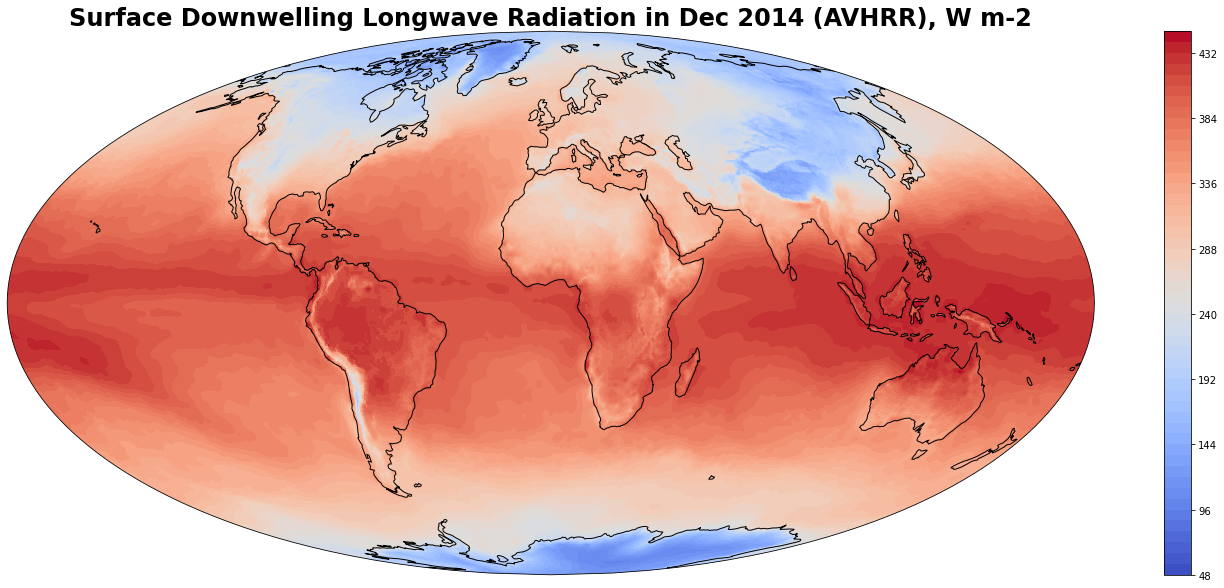

In [ ]:
fig = plt.figure(figsize = (25, 10))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.Mollweide())

plt.contourf(obs['SDL'].lon, obs['SDL'].lat, obs['SDL'], 60,
            transform = ccrs.PlateCarree(),
            cmap = 'coolwarm')
ax.coastlines()
ax.set_global()

# Add a color bar
plt.colorbar(ax = ax)
plt.title('Surface Downwelling Longwave Radiation in Dec 2014 (AVHRR), W m-2', 
          fontdict = {'fontsize' : '24', 'fontweight' : 'bold'} )
plt.show()

## 3. Regridding
As we could find out from the metadata of both datasets, their dimesions are different. We therefore need to regrid one of the datasets before we could spatially overlay them. We will use xESMF and ESMF libraries for this purpose. Please refer to the respective documentation to see the details and parameters of the functions from these packages (https://xesmf.readthedocs.io/en/latest/index.html, https://github.com/esmf-org/esmf).

In [9]:
# In case of problems, activate ESMF verbose mode
ESMF.Manager(debug = True)

# Regridding methods
method_list = ['bilinear','nearest_s2d', 'conservative', 'conservative_normed', 'patch']

# Function to generate the weights
# If grids have problems of degenerated cells near the poles there is the ignore_degenerate option
def regrid(ds_in, ds_out, method, periodic, unmapped_to_nan = True, ignore_degenerate = None):
    """Convenience function for calculating regridding weights"""
    return xe.Regridder(ds_in, ds_out, method, periodic = periodic, 
                        unmapped_to_nan = unmapped_to_nan, 
                        ignore_degenerate = ignore_degenerate)

Create a regridder for converting the observational dataset to match the model grid.

In [10]:
regridder = regrid(obs, dset, "bilinear", periodic = True, unmapped_to_nan = True, ignore_degenerate = None) 
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_720x1440_192x384_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (720, 1440) 
Output grid shape:          (192, 384) 
Periodic in longitude?      True

In [11]:
#Regrid the observational dataset and write write it to the xarray with the modeling dataset.
dset["AVHRR"] = regridder(obs.SDL, keep_attrs = True, skipna = True, na_thres = 1.0)
dset

<xarray.Dataset>
Dimensions:    (time: 1980, bnds: 2, lat: 192, lon: 384, member_id: 1)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lat        (lat) float64 -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
  * lon        (lon) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
  * member_id  (member_id) <U8 'r1i1p1f1'
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(60, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(384, 2), meta=np.ndarray>
    rlds       (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 60, 192, 384), meta=np.ndarray>
    AVHRR      (lat, lon) float64 132.0 132.0 132.1 132.1 ... 196.4 196.5 196.5
Attributes: (12/49)
    project_id:              CMIP6
    activity_id:             CMIP
    realization_index:       1
    forcing_index:           1
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.MPI-M.MPI-E...
    parent_time_units:       days since 1850-1-1 00:00:00
    ...                      ...
    source_type:             AOGCM
    frequency:               mon
    parent_mip_era:          CMIP6
    mip_era:                 CMIP6
    source:                  MPI-ESM1.2-HR (2017): \naerosol: none, prescribe...
    intake_esm_dataset_key:  CMIP.MPI-ESM1-2-HR.historical.Amon.gn

## 4. Validate the model
Finally, we can create a difference map between our datasets and calculate its corresponding bias and RMSE.

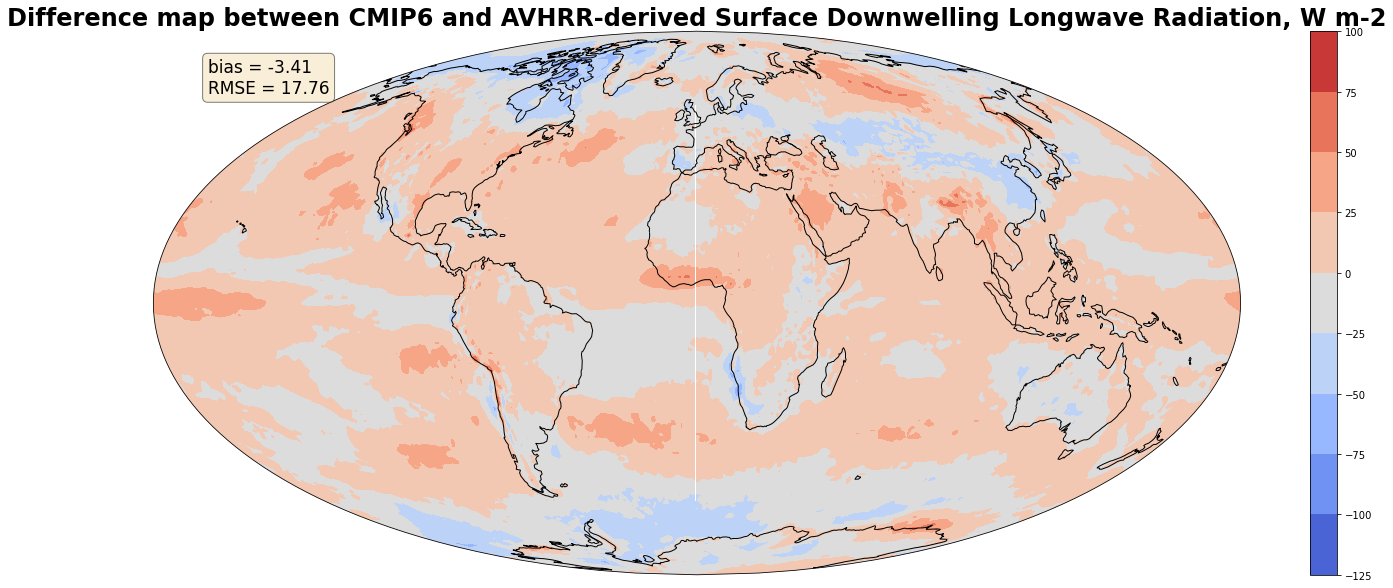

In [12]:
# Calculate the differene map
diff = dset['AVHRR'] - dset['rlds'].sel(time = '2014-12-16T12:00:00')
diff = diff[:,:,'member_id' == 'r1i1p1f1']

#Calculate the bias and the RMSE 
bias = diff.mean().values
rmse = np.sqrt(np.square(diff).sum()/np.square(diff).size).values

# Plot the results
fig = plt.figure(figsize = (25, 10))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.Mollweide())

plt.contourf(diff.lon, diff.lat, diff,
            transform = ccrs.PlateCarree(),
            cmap = 'coolwarm')
ax.coastlines()
ax.set_global()

# Print the bias and the RMSE in a textbox
textstr = '\n'.join((
    r'bias = %.2f' % (bias, ),
    r'RMSE = %.2f' % (rmse, )))

props = dict(boxstyle = 'round', facecolor = 'wheat', alpha = 0.5)
ax.text(0.05, 0.95, textstr, transform = ax.transAxes, fontsize = 17,
        verticalalignment = 'top', bbox = props)

# Add a color bar and a title
plt.colorbar(ax = ax)
plt.title('Difference map between CMIP6 and AVHRR-derived Surface Downwelling Longwave Radiation, W m-2', 
          fontdict = {'fontsize' : '24', 'fontweight' : 'bold'} )
plt.show()